In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.FastSCNN.models import fast_scnn
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing

In [3]:
# configuration
n_examples = 5
model_name = 'fast_scnn_ccncsa'
weights_path = "models/weights/"
dataset_path = "headsegmentation_dataset_ccncsa/"

In [4]:
# defining transforms
tH, tW = 256, 256
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # from ImageNet
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(mean, std)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path + 'training.xml')
X_train, X_test, Y_train, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

In [5]:
# training hyperparameters
device = 'cpu'
batch_size = 64
n_epochs = 50

# model, loss, score function
model = fast_scnn.FastSCNN(n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# training
results = training_and_testing.train_model(
    device, model, test_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, lr_scheduler=None, evaluate=True, verbose=True)

Device: cpu.
--- Epoch 1/50 ---
average_train_loss: 0.7532815552035044, average_train_score: 0.35568320110093715
average_val_loss: 1.5054897889494896, average_val_score: 0.3369629681110382
--- Epoch 2/50 ---
average_train_loss: 0.4799838856209156, average_train_score: 0.39615017383597617
average_val_loss: 0.44810669124126434, average_val_score: 0.3883208632469177
--- Epoch 3/50 ---
average_train_loss: 0.3992988702862762, average_train_score: 0.39394778290460275
average_val_loss: 0.6008558720350266, average_val_score: 0.3688587173819542
--- Epoch 4/50 ---
average_train_loss: 0.33567091476085575, average_train_score: 0.4093513391738714
average_val_loss: 0.37029649317264557, average_val_score: 0.38359829410910606
--- Epoch 5/50 ---
average_train_loss: 0.29058758845162946, average_train_score: 0.44378388621086295
average_val_loss: 0.3963349685072899, average_val_score: 0.4077736847102642
--- Epoch 6/50 ---
average_train_loss: 0.26558254035406337, average_train_score: 0.469008149795754
aver

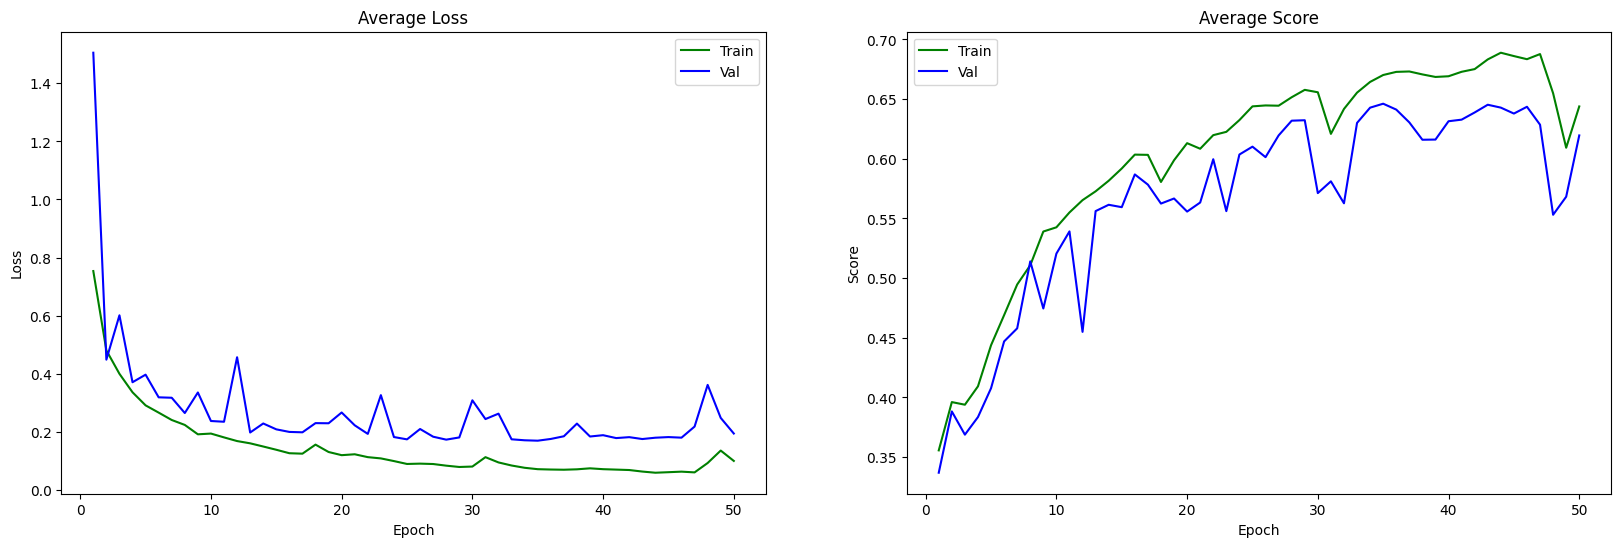

In [7]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [20]:
# resetting model, optimizer, learning rate scheduler
final_model = fast_scnn.FastSCNN(n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = 25
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')

Device: cpu.
--- Epoch 1/25 ---
average_train_loss: 0.4810874947315253, average_train_score: 0.39476225993951447
--- Epoch 2/25 ---
average_train_loss: 0.26254861776667515, average_train_score: 0.4912542037053961
--- Epoch 3/25 ---
average_train_loss: 0.2018285971764781, average_train_score: 0.5507700647708874
--- Epoch 4/25 ---
average_train_loss: 0.18089168407202919, average_train_score: 0.5749687517898671
--- Epoch 5/25 ---
average_train_loss: 0.14784557584691163, average_train_score: 0.607293124648108
--- Epoch 6/25 ---
average_train_loss: 0.1450192502155396, average_train_score: 0.6118782076282777
--- Epoch 7/25 ---
average_train_loss: 0.13430512926860708, average_train_score: 0.6241198199382727
--- Epoch 8/25 ---
average_train_loss: 0.12070480424568848, average_train_score: 0.6388306001534209
--- Epoch 9/25 ---
average_train_loss: 0.11413350244219177, average_train_score: 0.6467107076575791
--- Epoch 10/25 ---
average_train_loss: 0.11154425630102986, average_train_score: 0.650154

In [28]:
# loading pretrained final model
try:
    final_model
except:
    final_model = fast_scnn.FastSCNN(n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')

Device: cpu.

Inference completed in around 146 seconds.
batch_IoU_background: 0.9570227861404419
batch_IoU_lips: 0.49099022150039673
batch_IoU_eyes: 0.3784216046333313
batch_IoU_nose: 0.6721728444099426
batch_IoU_skin: 0.8499997854232788
batch_IoU_hair: 0.7888962626457214
batch_IoU_eyebrows: 0.3553004264831543
batch_IoU_ears: 0.6291913390159607
batch_IoU_teeth: 0.6637686491012573
batch_IoU_beard: 0.8478637933731079
batch_IoU_sunglasses: 0.9028354287147522
batch_mIoU=0.6851330399513245


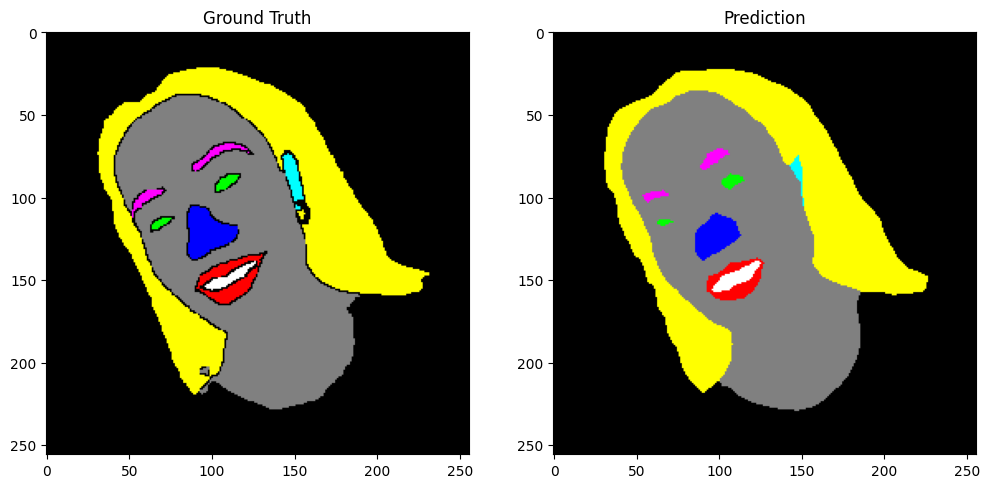

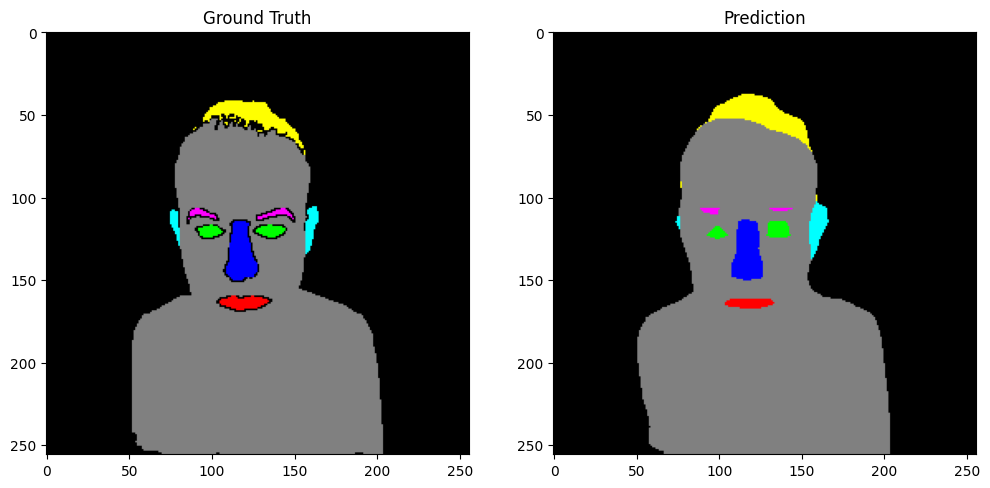

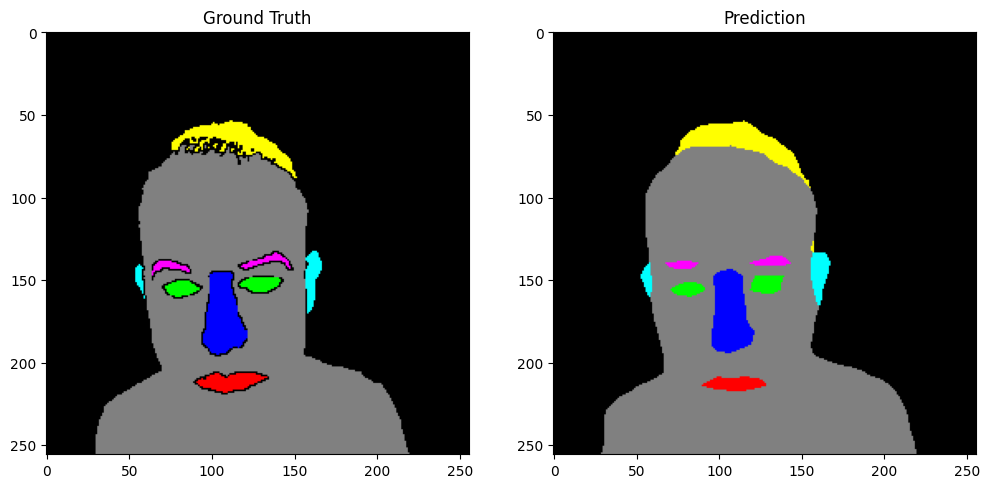

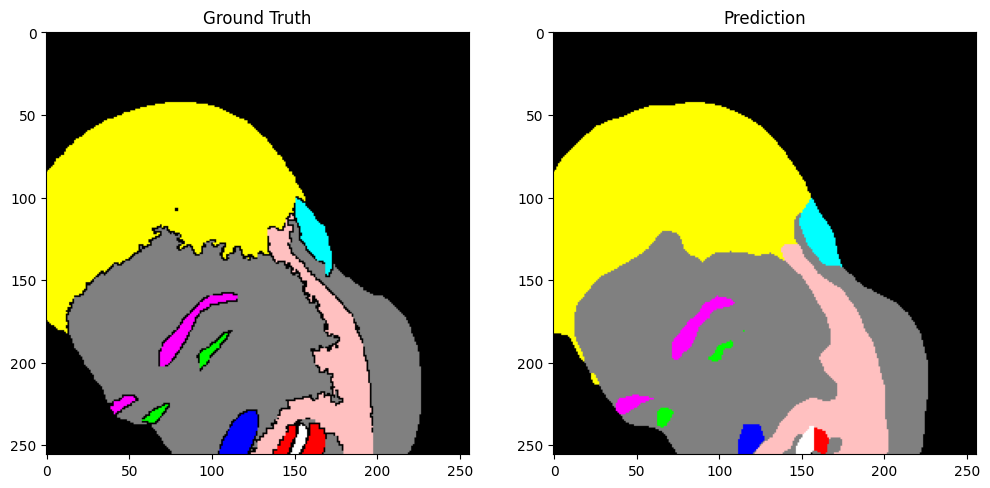

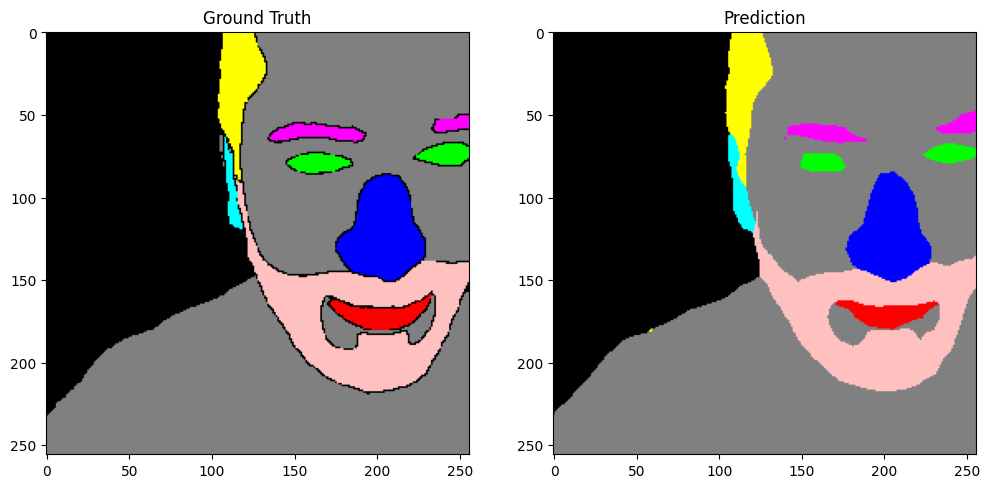

In [13]:
# plotting some random examples from test dataset
random_images = torch.zeros((n_examples, 3, tH, tW))
random_targets = torch.zeros((n_examples, n_classes, tH, tW))
for i in range(n_examples):
    random_idx = torch.randint(high=len(test_dataset), size=(1,))
    random_image, random_target = test_dataset[random_idx]
    random_images[i] = random_image
    random_targets[i] = random_target
with torch.no_grad():
    final_model.eval()
    random_output = final_model(random_images)[0]
channels_max, _ = torch.max(random_output, axis=1)
random_predictions = (random_output == channels_max.unsqueeze(axis=1))
for i in range(n_examples):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_targets[i], segmentation_labels.labels)))
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_predictions[i], segmentation_labels.labels)))